# Intrinsic Dimension Landscapes

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import random
from functools import partial
from jax.scipy.optimize import minimize

In [2]:
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [3]:
%config InlineBackend.figure_format = "retina"

## Intrinsic dimension toy

In [4]:
R = 10
y = jnp.arange(R) + 1


def f(theta_sub, P, theta_0, y):
    """
    Objective low-dimensional function takes a vector theta_sub
    such that dim(theta_sub) < dim(theta_0). We project theta_sub
    onto dim(theta_0), and reshape the input vector into a matrix
    of the form (10, ?). The loss is given by summing over each row
    of
    """
    theta = P @ theta_sub + theta_0
    y_hat = theta.reshape(10, -1).sum(axis=1)
    return jnp.sum((y_hat - y) ** 2)


def f_full(theta, y):
    """
    Objective full-dimensional function
    """
    y_hat = theta.reshape(10, -1).sum(axis=1)
    return jnp.sum((y_hat - y) ** 2)

In [5]:
D = 1000
theta_0 = jnp.zeros(D)
f_part = partial(f_full, y=y)
res = minimize(f_part, theta_0, method="bfgs")
optimal_loss = res.fun

In [6]:
key = random.PRNGKey(314)

d = 10
R = 10

theta_0 = random.normal(key, (D,)) / 10
theta_sub_0 = jnp.zeros(d)

choice_map = random.bernoulli(key, 1 / jnp.sqrt(D), shape=(D, d))
P = random.choice(key, jnp.array([-1, 1]), shape=(D, d)) * choice_map
P = P / jnp.linalg.norm(P, axis=0)

M = jnp.ones((R, D))
f_part = partial(f, P=P, theta_0=theta_0, y=y)
res = minimize(f_part, theta_sub_0, method="bfgs")

In [7]:
def optimize_subspace(key, d):
    key_weight, key_map, key_sign = random.split(key, 3)
    theta_0 = random.normal(key_weight, (D,)) / 10
    theta_sub_0 = jnp.zeros(d)

    choice_map = random.bernoulli(key_map, 1 / jnp.sqrt(D), shape=(D, d))
    P = random.choice(key_sign, jnp.array([-1, 1]), shape=(D, d)) * choice_map
    f_part = partial(f, P=P, theta_0=theta_0, y=y)
    res = minimize(f_part, theta_sub_0, method="bfgs", tol=1e-3)
    return res

In [8]:
key = random.PRNGKey(314)

dimensions = jnp.array(list(range(1, 16)) + [20, 30, 40])
keys = random.split(key, len(dimensions))

In [9]:
%%time
ans = {"dim": [], "loss": [], "w": []}

for key, dim in zip(keys, dimensions):
    print(f"@dim={dim}", end="\r")
    res = optimize_subspace(key, dim)
    ans["dim"].append(dim)
    ans["loss"].append(res.fun)
    ans["w"].append(res.x)

CPU times: user 39.2 s, sys: 922 ms, total: 40.2 s
Wall time: 33.9 s


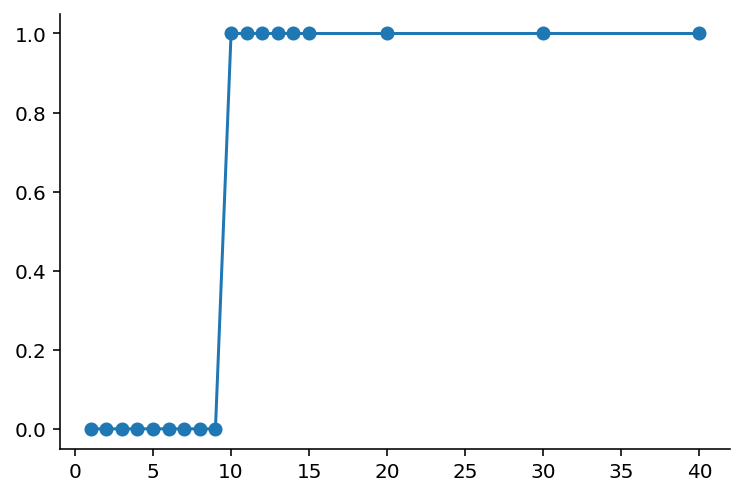

In [10]:
performance = jnp.exp(-jnp.array(ans["loss"])) / jnp.exp(-optimal_loss)
plt.plot(dimensions, performance, marker="o")

## MNIST

In [11]:
import optax
import flax.linen as nn
from typing import Sequence
from jax.nn import one_hot
from flax.training import train_state

In [12]:
import tensorflow_datasets as tfds

In [13]:
# Cannot be used with @jax.jit due to the
# variable number of features, unless we
# use static args
class MLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        for feat in self.features[:-1]:
            x = nn.relu(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1])(x)
        return nn.log_softmax(x)


class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.relu(nn.Dense(784)(x))
        x = nn.relu(nn.Dense(200)(x))
        x = nn.relu(nn.Dense(200)(x))
        x = nn.Dense(10)(x)
        return nn.log_softmax(x)

In [14]:
def get_datasets():
    """
    Load MNIST train and test datasets into memory
    """
    ds_builder = tfds.builder("mnist")
    ds_builder.download_and_prepare()
    train_ds = tfds.as_numpy(ds_builder.as_dataset(split="train", batch_size=-1))
    test_ds = tfds.as_numpy(ds_builder.as_dataset(split="test", batch_size=-1))
    train_ds["image"] = jnp.float32(train_ds["image"]) / 255.0
    test_ds["image"] = jnp.float32(test_ds["image"]) / 255.0
    return train_ds, test_ds


def cross_entropy_loss(*, logits, labels):
    one_hot_labels = jax.nn.one_hot(labels, num_classes=10)
    return -jnp.mean(jnp.sum(one_hot_labels * logits, axis=-1))


def compute_metrics(*, logits, labels):
    loss = cross_entropy_loss(logits=logits, labels=labels)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    metrics = {
        "loss": loss,
        "accuracy": accuracy,
    }
    return metrics


def create_train_state(rng, learning_rate, momentum):
    """Creates initial `TrainState`."""
    mlp = MLP()
    params = mlp.init(rng, jnp.ones((1, 28**2)))["params"]
    tx = optax.sgd(learning_rate, momentum)
    return train_state.TrainState.create(apply_fn=mlp.apply, params=params, tx=tx)


@jax.jit
def train_step(state, batch):
    """Train for a single step."""

    def loss_fn(params):
        logits = MLP().apply({"params": params}, batch["image"])
        loss = cross_entropy_loss(logits=logits, labels=batch["label"])
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, logits), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    metrics = compute_metrics(logits=logits, labels=batch["label"])
    return state, metrics

### Setup

In [15]:
train_ds, test_ds = get_datasets()
train_ds["image"] = train_ds["image"].reshape(-1, 28**2)
test_ds["image"] = test_ds["image"].reshape(-1, 28**2)

In [16]:
n_classes = len(jnp.unique(train_ds["label"]))

### Training

In [ ]:
%%time
key = random.PRNGKey(314)
learning_rate = 0.1
momentum = 0.9
state = create_train_state(key, learning_rate, momentum)

n_epochs = 100
for e in range(n_epochs):
    state, metrics = train_step(state, train_ds)
    epoch_metrics = jax.device_get(metrics)
    epoch_accuracy = epoch_metrics["accuracy"]
    epoch_loss = epoch_metrics["loss"]
    end = "\n" if e % 9 == 0 else "\r"
    metric_str = f"epoch: {e+1:03} || acc: {epoch_accuracy:0.2%} || loss:{epoch_loss:0.2f}"
    print(metric_str, end=end)

## Subpace

In [39]:
%load_ext line_profiler

In [19]:
import numpy as np
from time import time
import os
import requests

In [20]:
training_utils_url = "https://raw.githubusercontent.com/ganguli-lab/degrees-of-freedom/main/training_utils.py"
filename = "../scripts/training_utils.py"

if not os.path.exists(filename):
    print(f"Writing to {filename}")
    r = requests.get(training_utils_url)
    with open(filename, "w") as f:
        f.write(r.text)

In [21]:
import sys

sys.path.append("../scripts/")
import training_utils

In [22]:
@jax.vmap
def cross_entropy_loss(logits, label):
    return -logits[label]


@jax.jit
def normal_loss(params, batch):
    logits = MLP().apply({"params": params}, batch["image"])
    logits = jax.nn.log_softmax(logits)

    loss = jnp.mean(cross_entropy_loss(logits, batch["label"]))
    return loss


@jax.jit
def normal_accuracy(params, batch):
    logits = MLP().apply({"params": params}, batch["image"])
    logits = jax.nn.log_softmax(logits)
    return jnp.mean(jnp.argmax(logits, -1) == batch["label"])

In [23]:
key = random.PRNGKey(314)
learning_rate = 0.1
momentum = 0.9
state = create_train_state(key, learning_rate, momentum)

In [24]:
init_params = state.params
leaves0, treedef = jax.tree_flatten(init_params)
vec0, shapes_list = training_utils.flatten_leaves(leaves0)

# To-do: add explicit dependence on , vec0, treedef, ahd shapes_list
def projected_loss(theta_subspace, batch):
    """
    1. Project theta_subspace ∈ R^d => theta ∈ R^D
    2. Compute loss of the model w.r.t. theta_subspace
    """
    projected_subspace_params = training_utils.theta_to_paramstree(theta_subspace, M, vec0, treedef, shapes_list)
    return normal_loss(projected_subspace_params, batch)


loss_grad_wrt_theta = jax.grad(projected_loss)

In [25]:
flat_params, *_ = jax.tree_flatten(init_params)
D = sum([np.prod(params.shape) for params in flat_params])
print(f"Problem dimension D={D:,}")

Problem dimension D=814,650


In [26]:
np.random.seed(314)
d = 750
M = jnp.array(training_utils.generate_projection(d, D))
M.shape

(750, 814650)

In [27]:
@jax.jit
def adam_update(grads, params, mass, velocity, hyperparams):

    mass = hyperparams["beta_1"] * mass + (1.0 - hyperparams["beta_1"]) * grads
    velocity = hyperparams["beta_2"] * velocity + (1.0 - hyperparams["beta_2"]) * (grads**2.0)
    # Bias correction
    hat_mass = mass / (1 - hyperparams["beta_1"])
    hat_velocity = velocity / (1 - hyperparams["beta_2"])
    # Update
    params = params - hyperparams["lr"] / (jnp.sqrt(hat_velocity) + hyperparams["epsilon"]) * hat_mass

    return params, mass, velocity

In [83]:
%%time

n_epochs = 300
hyperparams = {"lr": 1e-1, "beta_1": 0.9, "beta_2": 0.999, "epsilon": 1e-7}

theta = jnp.zeros((1, d))
mass = jnp.zeros((1, d))
velocity = jnp.zeros((1, d))

print(f"Testing subpace {d=}")
for e in range(n_epochs):
    grads = loss_grad_wrt_theta(theta, train_ds)
    theta, mass, velocity = adam_update(grads, theta, mass, velocity, hyperparams)
    params_now = training_utils.theta_to_paramstree(theta, M, vec0, treedef, shapes_list)
    epoch_loss = normal_loss(params_now, train_ds)
    epoch_accuracy = normal_accuracy(params_now, train_ds)
    if e % 100 == 0 or e == n_epochs - 1:
        end = "\n"
        epoch_val_accuracy = normal_accuracy(params_now, test_ds)
        val_str = f" || val acc: {epoch_val_accuracy:0.2%}"
    else:
        end = "\r"
        val_str = ""

    metric_str = f"epoch: {e+1:03} || acc: {epoch_accuracy:0.2%} || loss:{epoch_loss:0.2f}"
    metric_str += val_str
    print(metric_str, end=end)

Testing subpace d=750
epoch: 001 || acc: 17.38% || loss:2.28 || val acc: 17.81%
epoch: 101 || acc: 88.71% || loss:0.37 || val acc: 89.14%
epoch: 201 || acc: 90.07% || loss:0.32 || val acc: 90.25%
epoch: 300 || acc: 90.68% || loss:0.31 || val acc: 90.76%
CPU times: user 39.3 s, sys: 10.3 s, total: 49.6 s
Wall time: 40.1 s


In [49]:
n_epochs = 300

hyperparams = {"lr": 1e-1, "beta_1": 0.9, "beta_2": 0.999, "epsilon": 1e-7}


def get_metric_str(epoch, params, test_ds, n_epochs, epoch_accuracy, epoch_loss):
    if epoch % 100 == 0 or epoch == n_epochs - 1:
        end = "\n"
        epoch_val_accuracy = normal_accuracy(params, test_ds)
        val_str = f" || val acc: {epoch_val_accuracy:0.2%}"
    else:
        end = "\r"
        val_str = ""

    metric_str = f"epoch: {epoch+1:03} || acc: {epoch_accuracy:0.2%} || loss:{epoch_loss:0.2f}"
    metric_str += val_str
    return metric_str, end


def train_mlp_subspace(d, D, n_epochs, hyperparams, seed=None):
    np.random.seed(seed)
    M = jnp.array(training_utils.generate_projection(d, D))
    theta, mass, velocity = jnp.zeros((3, 1, d))

    @jax.jit
    def projected_loss(theta_subspace, batch):
        """
        1. Project theta_subspace ∈ R^d => theta ∈ R^D
        2. Compute loss of the model w.r.t. theta_subspace
        """
        projected_subspace_params = training_utils.theta_to_paramstree(theta_subspace, M, vec0, treedef, shapes_list)
        return normal_loss(projected_subspace_params, batch)

    loss_grad_wrt_theta = jax.grad(projected_loss)

    for e in range(n_epochs):
        grads = loss_grad_wrt_theta(theta, train_ds)
        theta, mass, velocity = adam_update(grads, theta, mass, velocity, hyperparams)
        params_now = training_utils.theta_to_paramstree(theta, M, vec0, treedef, shapes_list)

        epoch_loss = normal_loss(params_now, train_ds)
        epoch_accuracy = normal_accuracy(params_now, train_ds)
        metric_str, end = get_metric_str(e, params_now, test_ds, n_epochs, epoch_accuracy, epoch_loss)

        print(metric_str, end=end)

    return params_now, (epoch_loss, epoch_accuracy)

In [47]:
d = 750
# params, _ = train_mlp_subspace(d, D, n_epochs, hyperparams, 314)

In [48]:
%lprun -u 1 -f train_mlp_subspace params, _ = train_mlp_subspace(d, D, n_epochs, hyperparams, 314)

epoch: 001 || acc: 17.38% || loss:2.28 || val acc: 17.81%
epoch: 101 || acc: 88.71% || loss:0.37 || val acc: 89.14%
epoch: 201 || acc: 90.07% || loss:0.32 || val acc: 90.25%
epoch: 300 || acc: 90.68% || loss:0.31 || val acc: 90.76%


Timer unit: 1 s

Total time: 68.5034 s
File: <ipython-input-36-6dbbc81c22e4>
Function: train_mlp_subspace at line 24

Line #      Hits         Time  Per Hit   % Time  Line Contents
    24                                           def train_mlp_subspace(d, D, n_epochs, hyperparams, seed=None):
    25         1          0.0      0.0      0.0      np.random.seed(seed)
    26         1         18.8     18.8     27.4      M = jnp.array(training_utils.generate_projection(d, D))
    27         1          0.0      0.0      0.0      theta, mass, velocity = jnp.zeros((3, 1, d))
    28                                               
    29         1          0.0      0.0      0.0      def projected_loss(theta_subspace, batch):
    30                                                   """
    31                                                   1. Project theta_subspace ∈ R^d => theta ∈ R^D
    32                                                   2. Compute loss of the model w.r.t. theta_subspace
  

----

### All together

In [26]:
subspace_dims = [2] + list(range(10, 1300, 20))

val_losses = []
val_acc = []
for d in subspace_dims:
    print(f"\n\nTesting subpace {d=}")
    init_time = time()
    M = jnp.array(training_utils.generate_projection(d, D))

    leaves0, treedef = jax.tree_flatten(init_params)
    vec0, shapes_list = training_utils.flatten_leaves(leaves0)

    def projected_loss(theta_subspace, batch):
        """
        1. Project theta_subspace ∈ R^d => theta ∈ R^D.
        2. Compute loss of the model w.r.t. theta_subspace
        """
        projected_subspace_params = training_utils.theta_to_paramstree(theta_subspace, M, vec0, treedef, shapes_list)
        return normal_loss(projected_subspace_params, batch)

    loss_grad_wrt_theta = jax.grad(projected_loss)

    theta = jnp.zeros((1, d))
    lr = 1e-1
    n_epochs = 300

    beta_1 = 0.9
    beta_2 = 0.999
    epsilon = 1e-07
    mass = jnp.zeros((1, d))
    velocity = jnp.zeros((1, d))

    for e in range(n_epochs):
        grads = loss_grad_wrt_theta(theta, train_ds)

        # *** Parameter update
        mass = beta_1 * mass + (1.0 - beta_1) * grads
        velocity = beta_2 * velocity + (1.0 - beta_2) * (grads**2.0)

        # Bias correction
        hat_mass = mass / (1.0 - beta_1)
        hat_velocity = velocity / (1.0 - beta_2)

        # Update
        theta = theta - lr / (jnp.sqrt(hat_velocity) + epsilon) * hat_mass
        # theta = theta - lr * grads
        # *******************

        params_now = training_utils.theta_to_paramstree(theta, M, vec0, treedef, shapes_list)
        epoch_loss = normal_loss(params_now, train_ds)
        epoch_accuracy = normal_accuracy(params_now, train_ds)
        if e % 100 == 0 or e == n_epochs - 1:
            end = "\n"
            epoch_val_accuracy = normal_accuracy(params_now, test_ds)
            epoch_val_loss = normal_loss(params_now, test_ds)
            val_str = f" || val acc: {epoch_val_accuracy:0.2%}"
        else:
            end = "\r"
            val_str = ""

        metric_str = f"epoch: {e+1:03} || acc: {epoch_accuracy:0.2%} || loss:{epoch_loss:0.2f}"
        metric_str += val_str
        print(metric_str, end=end)

    val_losses.append(epoch_val_loss)
    val_acc.append(epoch_val_accuracy)
    end_time = time()
    print(f"Total run: {end_time - init_time:0.2f}s")



Testing subpace d=2
epoch: 001 || acc: 10.19% || loss:2.31 || val acc: 10.65%
epoch: 101 || acc: 10.15% || loss:2.31 || val acc: 10.43%
epoch: 201 || acc: 10.18% || loss:2.31 || val acc: 10.42%
epoch: 300 || acc: 10.15% || loss:2.31 || val acc: 10.44%
Total run: 33.31s


Testing subpace d=10
epoch: 001 || acc: 10.27% || loss:2.31 || val acc: 10.82%
epoch: 101 || acc: 19.63% || loss:2.23 || val acc: 20.17%
epoch: 201 || acc: 23.62% || loss:2.20 || val acc: 23.81%
epoch: 300 || acc: 24.58% || loss:2.19 || val acc: 24.62%
Total run: 31.10s


Testing subpace d=30
epoch: 001 || acc: 10.45% || loss:2.31 || val acc: 10.81%
epoch: 101 || acc: 33.25% || loss:1.96 || val acc: 32.72%
epoch: 201 || acc: 35.33% || loss:1.88 || val acc: 35.99%
epoch: 300 || acc: 35.52% || loss:1.87 || val acc: 35.66%
Total run: 31.74s


Testing subpace d=50
epoch: 001 || acc: 10.72% || loss:2.31 || val acc: 11.24%
epoch: 101 || acc: 39.07% || loss:1.78 || val acc: 40.18%
epoch: 201 || acc: 42.94% || loss:1.69 || v

Text(0, 0.5, 'Validation accuracy')

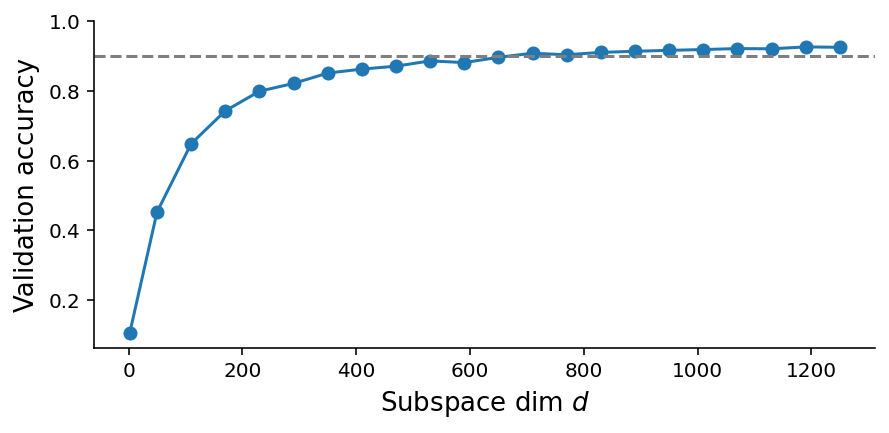

In [55]:
fig, ax = plt.subplots(figsize=(7, 3))
plt.plot(subspace_dims[::3], val_acc[::3], marker="o")
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0])
plt.axhline(y=0.9, c="tab:gray", linestyle="--")
plt.xlabel("Subspace dim $d$", fontsize=13)
plt.ylabel("Validation accuracy", fontsize=13)

## References 
1. https://github.com/ganguli-lab/degrees-of-freedom
2. https://flax.readthedocs.io/en/latest/notebooks/annotated_mnist.html
3. https://github.com/uber-research/intrinsic-dimension